<a href="https://colab.research.google.com/github/landier/game-of-life/blob/main/GameOfLife_Lenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LENIA

In this notebook,  we explore the Lenia system starting from the Game Of Life, inspired by "From Conway to Lenia" by Bert Chan.
https://chakazul.github.io/lenia.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as sp

We define a small convenience function to produce a movie from an initial array and an evolution function.

In [2]:
DPI = 30

def produce_movie(X, evolve, save_path, num_steps = 100, cmap = None, interpolation = 'bicubic'):

    if len(X.shape) == 2 and cmap is None:
        cmap = 'gray_r'

    fig = plt.figure(figsize=(16, 9))
    im = plt.imshow(X, cmap=cmap, interpolation=interpolation, vmin=0, vmax=1)
    plt.axis('off')

    def update(i):

        if(i%(num_steps//10)==0):
            print('Step {}/{}'.format(i, num_steps))

        if (i==0):
            return im,
        nonlocal X
        X = evolve(X)
        im.set_array(X)
        return im,

    ani = animation.FuncAnimation(fig, update, num_steps, interval=50, blit=True)
    ani.save(save_path, fps=25, dpi = DPI)

def gauss(x, mu, sigma):
    return np.exp(-0.5 * ((x-mu)/sigma)**2)

def produce_movie_multi(Xs, evolve, save_path, num_steps = 100, interpolation = 'bicubic'):

    fig = plt.figure(figsize=(16, 9))
    im = plt.imshow(np.dstack(Xs), interpolation=interpolation)
    plt.axis('off')

    def update(i):
        nonlocal Xs
        Xs = evolve(Xs)
        im.set_array(np.dstack(Xs))
        return im,

    ani = animation.FuncAnimation(fig, update, num_steps, interval=50, blit=True)
    ani.save(save_path, fps=25, dpi = DPI)

<Figure size 1200x1200 with 0 Axes>

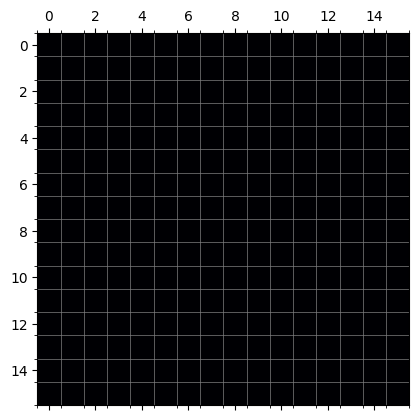

<Figure size 1200x1200 with 0 Axes>

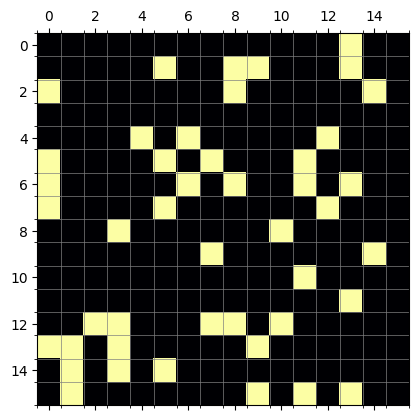

<Figure size 1200x1200 with 0 Axes>

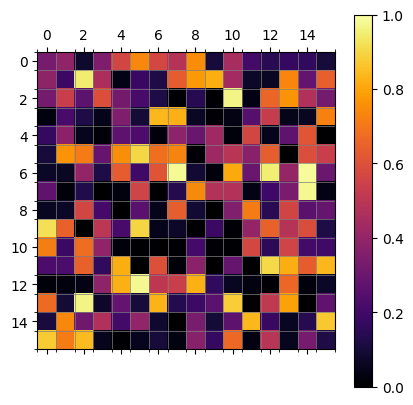

In [3]:
plt.figure(figsize=(12, 12))
X = np.zeros((16, 16))
plt.matshow(X,cmap='inferno',interpolation='none',vmin=0,vmax=1)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, X.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, X.shape[0], 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
plt.savefig('grid0.png', dpi = DPI)


np.random.seed(1)
X = np.random.choice([0, 1], size=(16, 16), p=[0.85,0.15])
plt.figure(figsize=(12, 12))
plt.matshow(X,cmap='inferno',interpolation='none',vmin=0,vmax=1)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, X.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, X.shape[0], 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
plt.savefig('grid.png', dpi = DPI)

X = np.random.rand(16, 16)
plt.figure(figsize=(12, 12))
plt.matshow(X**2,cmap='inferno',interpolation='none',vmin=0,vmax=1)
ax = plt.gca()
ax.set_xticks(np.arange(-.5, X.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, X.shape[0], 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
plt.colorbar()
plt.savefig('grid2.png', dpi = DPI)



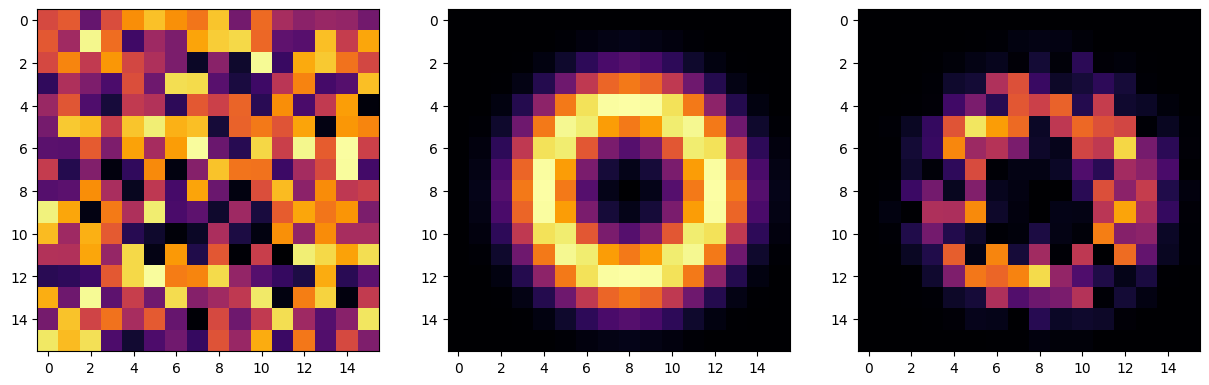

In [4]:
#define and plot a filter
R = 8
y, x = np.ogrid[-R:R, -R:R]
distance = np.sqrt((x)**2 + (y)**2) / R

mu = 0.5
sigma = 0.15
K = gauss(distance, mu, sigma)
K[distance > 1] = 0               # Cut at d=1
K = K / np.max(K)     # Normalize

# plot X
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(X, interpolation='none',cmap='inferno',vmin=0,vmax=1)
plt.subplot(132)
plt.imshow(K, interpolation='none',cmap='inferno',vmin=0,vmax=1)
plt.subplot(133)
plt.imshow(X*K, interpolation='none',cmap='inferno',vmin=0,vmax=1)
plt.savefig('filtering.png', dpi = 300)

## 1. Simple Game Of Life

We first simulate a vanilla GoL with periodic boundary conditions, using the usual rules :

- A living cell with 2 neighbours survives.
- A cell with 3 neighbours survives or is born.

Step 0/100
Step 0/100
Step 0/100
Step 0/100
Step 10/100
Step 20/100
Step 30/100
Step 40/100
Step 50/100
Step 60/100
Step 70/100
Step 80/100
Step 90/100


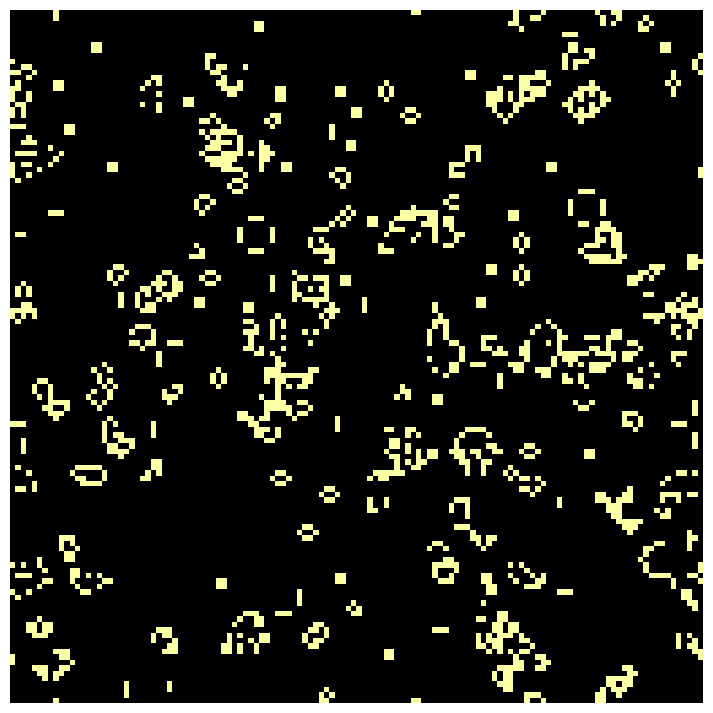

In [5]:
def evolve_game_of_life(X):
    # Use roll for periodic boundary conditions.
    neighbours_count = sum(np.roll(np.roll(X, i, 0), j, 1) for i in (-1, 0, 1) for j in (-1, 0, 1) if (i != 0 or j != 0))
    return (neighbours_count == 3) | (X & (neighbours_count == 2))

np.random.seed(42)
X = np.random.randint(0, 2, (128, 128))
produce_movie(X, evolve_game_of_life, '1-game_of_life.mp4', 100, cmap = 'inferno', interpolation='none')

## 2. Game Of Life with continuous filter and growth

We reformulate the Game Of Life in a continuous way. For that we use a growth function that has the appropriate values for the number of neighbours :
- A growth of 0 for 2 neighbours.
- A growth of +1 for 3 neighbours.
- A growth of -1 for <2 or >3 neighbours.

Let's first define and plot the growth function, and check it interpolates well between the values we want.

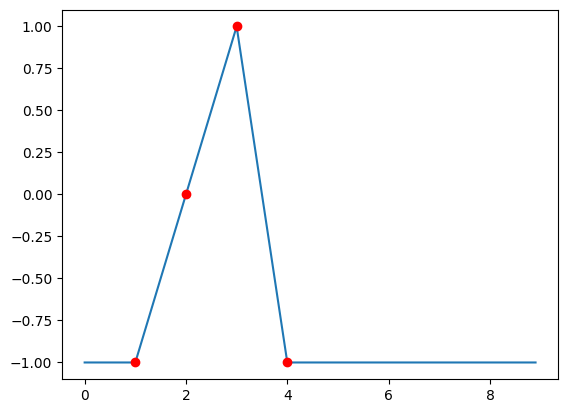

In [6]:
def growth_GoL(u):
    mask1 = (u >= 1) & (u <= 3)
    mask2 = (u > 3) & (u <= 4)
    return -1 + (u - 1) * mask1 + 8 * (1 - u/4) * mask2

a = np.arange(0, 9, 0.1)
plt.plot(a, growth_GoL(a))
ring_strengths = np.array([1, 2, 3, 4])
plt.plot(ring_strengths, growth_GoL(ring_strengths), 'ro')

Now we use a convolution filter to count the number of neighbours. The filter is a 3x3 matrix with 1s everywhere except in the center.
To evolve the array, we apply the growth function to the convolution result and add it to the array, then we clip the result to [0, 1].

Step 0/100
Step 0/100
Step 0/100
Step 0/100
Step 10/100
Step 20/100
Step 30/100
Step 40/100
Step 50/100
Step 60/100
Step 70/100
Step 80/100
Step 90/100


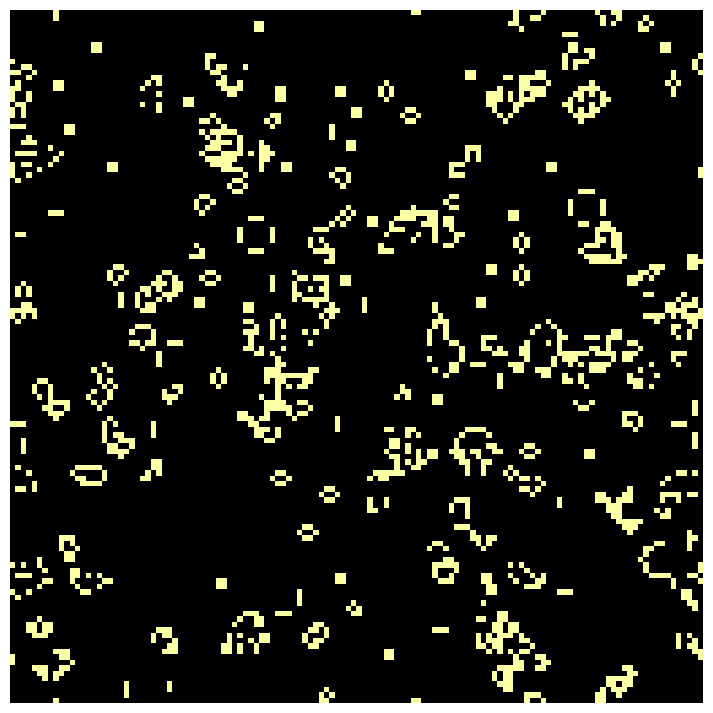

In [7]:
def evolve_game_of_life_filter_growth(X):
    neighbour_filter = np.array([[1, 1, 1],[1, 0, 1],[1, 1, 1]])
    neighbour_count = sp.signal.convolve2d(X, neighbour_filter, mode='same', boundary='wrap')
    X = X + growth_GoL(neighbour_count)
    X = np.clip(X, 0, 1)
    return X

np.random.seed(42)
X = np.random.randint(0, 2, (128, 128))
produce_movie(X, evolve_game_of_life, '2-game_of_life-filter-growth.mp4', 100, cmap = 'inferno',interpolation='none')

## 3. Lenia basics

Lenia generalizes the Game Of Life by using a continuous convolution filter, a continuous growth function and continuous time (or discrete time with an arbitrary small timestep).

### 3.1 Create a ring filter

To generalize the "neighbour" counting, first we create a ring filter with a gaussian profile. It is obtained by computing the distance $d$ to the center and applying a gaussian function $g$ :
$$
g(d) = e^{-\frac{(d-\mu)^2}{2\sigma^2}}
$$
With $\mu=0.5$ we get a ring. We normalize the filter so that the sum of all values is 1 and cut it at d=1.

Text(0.5, 1.0, 'Convolution filter')

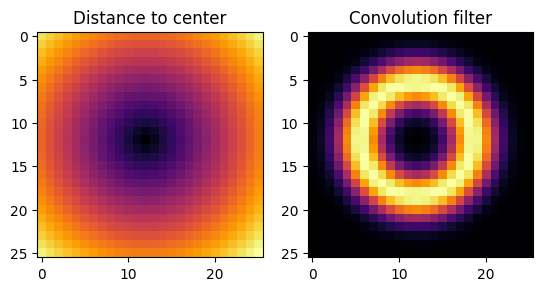

In [8]:
# Convolution filter is a ring with a gaussian profile created from the distance matrix
R = 13
y, x = np.ogrid[-R:R, -R:R]
distance = np.sqrt((1+x)**2 + (1+y)**2) / R

mu = 0.5
sigma = 0.15
K_lenia = gauss(distance, mu, sigma)
K_lenia[distance > 1] = 0               # Cut at d=1
K_lenia = K_lenia / np.sum(K_lenia)     # Normalize

plt.subplot(121)
plt.imshow(distance, interpolation='none',cmap='inferno')
plt.title('Distance to center')
plt.subplot(122)
plt.imshow(K_lenia, interpolation='none',cmap='inferno')
plt.title('Convolution filter')

### 3.2 Growth function
For the growth function we use a gaussian with a baseline of -1 and a peak of 1.

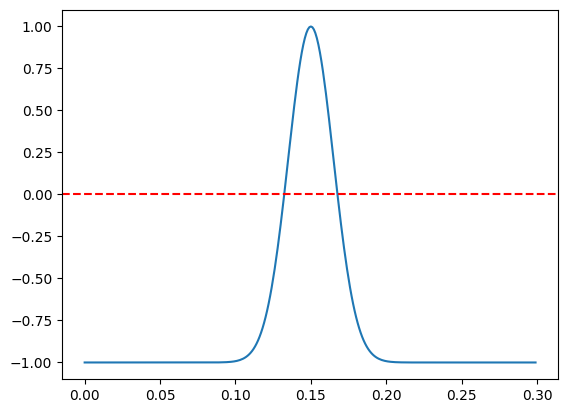

In [9]:
def growth_lenia(u):
    mu = 0.15
    sigma = 0.015
    return -1 + 2 * gauss(u,mu,sigma)        # Baseline -1, peak +1

a = np.arange(0, 0.3, 0.001)
plt.plot(a, growth_lenia(a))
plt.axhline(0, linestyle='--', color='red')

In [10]:
dt = 0.1
def evolve_lenia(X):
    U = sp.signal.convolve2d(X, K_lenia, mode='same', boundary='wrap')
    X = X + dt * growth_lenia(U)
    X = np.clip(X, 0, 1)
    return X

### Spot initial configuration

Step 0/500
Step 0/500
Step 0/500
Step 0/500
Step 50/500
Step 100/500
Step 150/500
Step 200/500
Step 250/500
Step 300/500
Step 350/500
Step 400/500
Step 450/500


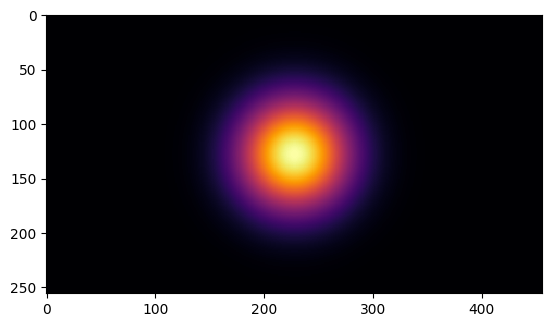

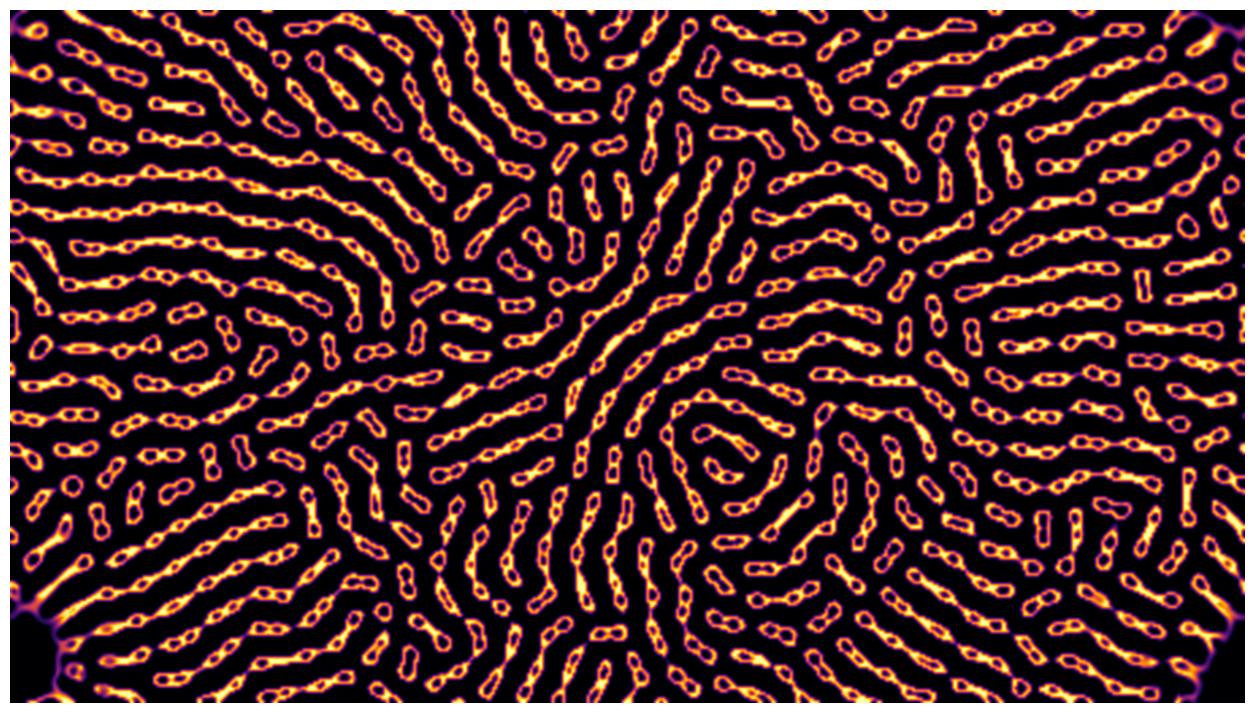

In [11]:
N = 256
M = int(np.ceil((16*N)/9))
X = np.ones((M, N))
# Gaussian spot centered in the middle
radius = 36
y, x = np.ogrid[-N//2:N//2, -M//2:M//2]
X = np.exp(-0.5 * (x*x + y*y) / (radius*radius))
plt.imshow(X, cmap='inferno', interpolation='none')

produce_movie(X, evolve_lenia, '3-lenia_spot.mp4', 500, cmap = 'inferno')

In [12]:
# Random initial configuration

Step 0/200
Step 0/200
Step 0/200
Step 0/200
Step 20/200
Step 40/200
Step 60/200
Step 80/200
Step 100/200
Step 120/200
Step 140/200
Step 160/200
Step 180/200


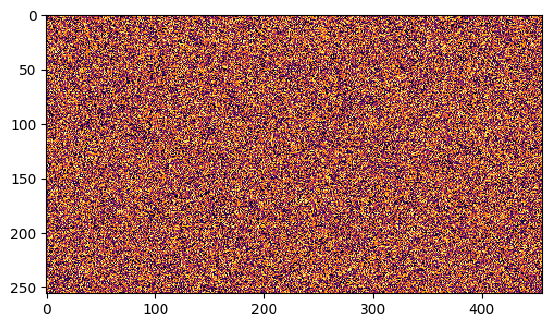

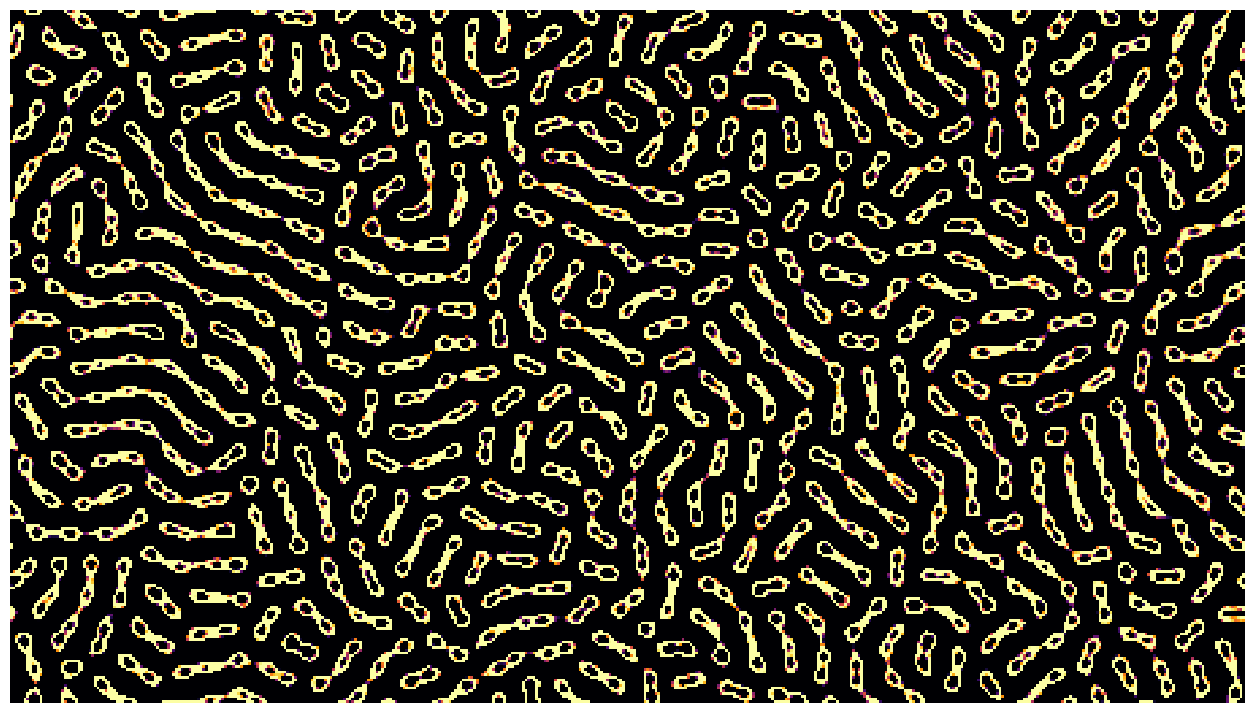

In [13]:
N = 256
M = int(np.ceil((16*N)/9))
X = np.random.rand(N, M)
plt.imshow(X, cmap='inferno', interpolation='none')

produce_movie(X, evolve_lenia, '4-lenia_random.mp4', 200, cmap = 'inferno',interpolation='none')

### 3.3 Orbium initial configuration

We load the Orbium configuration from the original Lenia website.

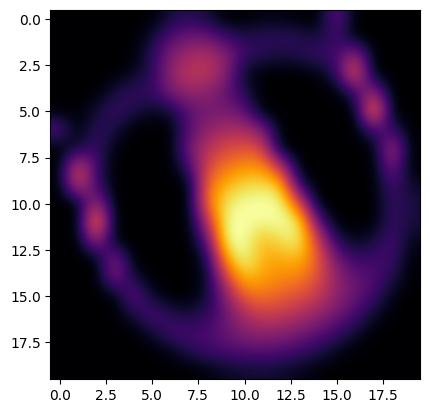

In [14]:
orbium = np.array([[0,0,0,0,0,0,0.1,0.14,0.1,0,0,0.03,0.03,0,0,0.3,0,0,0,0], [0,0,0,0,0,0.08,0.24,0.3,0.3,0.18,0.14,0.15,0.16,0.15,0.09,0.2,0,0,0,0], [0,0,0,0,0,0.15,0.34,0.44,0.46,0.38,0.18,0.14,0.11,0.13,0.19,0.18,0.45,0,0,0], [0,0,0,0,0.06,0.13,0.39,0.5,0.5,0.37,0.06,0,0,0,0.02,0.16,0.68,0,0,0], [0,0,0,0.11,0.17,0.17,0.33,0.4,0.38,0.28,0.14,0,0,0,0,0,0.18,0.42,0,0], [0,0,0.09,0.18,0.13,0.06,0.08,0.26,0.32,0.32,0.27,0,0,0,0,0,0,0.82,0,0], [0.27,0,0.16,0.12,0,0,0,0.25,0.38,0.44,0.45,0.34,0,0,0,0,0,0.22,0.17,0], [0,0.07,0.2,0.02,0,0,0,0.31,0.48,0.57,0.6,0.57,0,0,0,0,0,0,0.49,0], [0,0.59,0.19,0,0,0,0,0.2,0.57,0.69,0.76,0.76,0.49,0,0,0,0,0,0.36,0], [0,0.58,0.19,0,0,0,0,0,0.67,0.83,0.9,0.92,0.87,0.12,0,0,0,0,0.22,0.07], [0,0,0.46,0,0,0,0,0,0.7,0.93,1,1,1,0.61,0,0,0,0,0.18,0.11], [0,0,0.82,0,0,0,0,0,0.47,1,1,0.98,1,0.96,0.27,0,0,0,0.19,0.1], [0,0,0.46,0,0,0,0,0,0.25,1,1,0.84,0.92,0.97,0.54,0.14,0.04,0.1,0.21,0.05], [0,0,0,0.4,0,0,0,0,0.09,0.8,1,0.82,0.8,0.85,0.63,0.31,0.18,0.19,0.2,0.01], [0,0,0,0.36,0.1,0,0,0,0.05,0.54,0.86,0.79,0.74,0.72,0.6,0.39,0.28,0.24,0.13,0], [0,0,0,0.01,0.3,0.07,0,0,0.08,0.36,0.64,0.7,0.64,0.6,0.51,0.39,0.29,0.19,0.04,0], [0,0,0,0,0.1,0.24,0.14,0.1,0.15,0.29,0.45,0.53,0.52,0.46,0.4,0.31,0.21,0.08,0,0], [0,0,0,0,0,0.08,0.21,0.21,0.22,0.29,0.36,0.39,0.37,0.33,0.26,0.18,0.09,0,0,0], [0,0,0,0,0,0,0.03,0.13,0.19,0.22,0.24,0.24,0.23,0.18,0.13,0.05,0,0,0,0], [0,0,0,0,0,0,0,0,0.02,0.06,0.08,0.09,0.07,0.05,0.01,0,0,0,0,0]])
plt.imshow(orbium, cmap='inferno',interpolation='bicubic',vmin=0,vmax=1)

We initialize the array with the Orbium configuration in a corner

Step 0/800
Step 0/800
Step 0/800
Step 0/800
Step 80/800
Step 160/800
Step 240/800
Step 320/800
Step 400/800
Step 480/800
Step 560/800
Step 640/800
Step 720/800


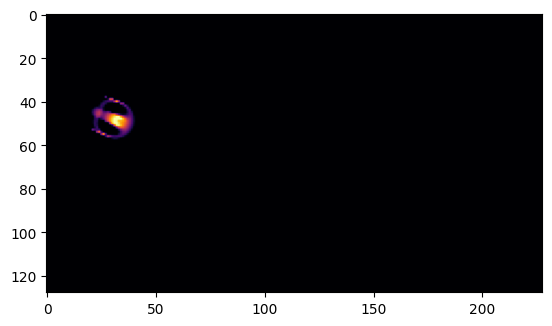

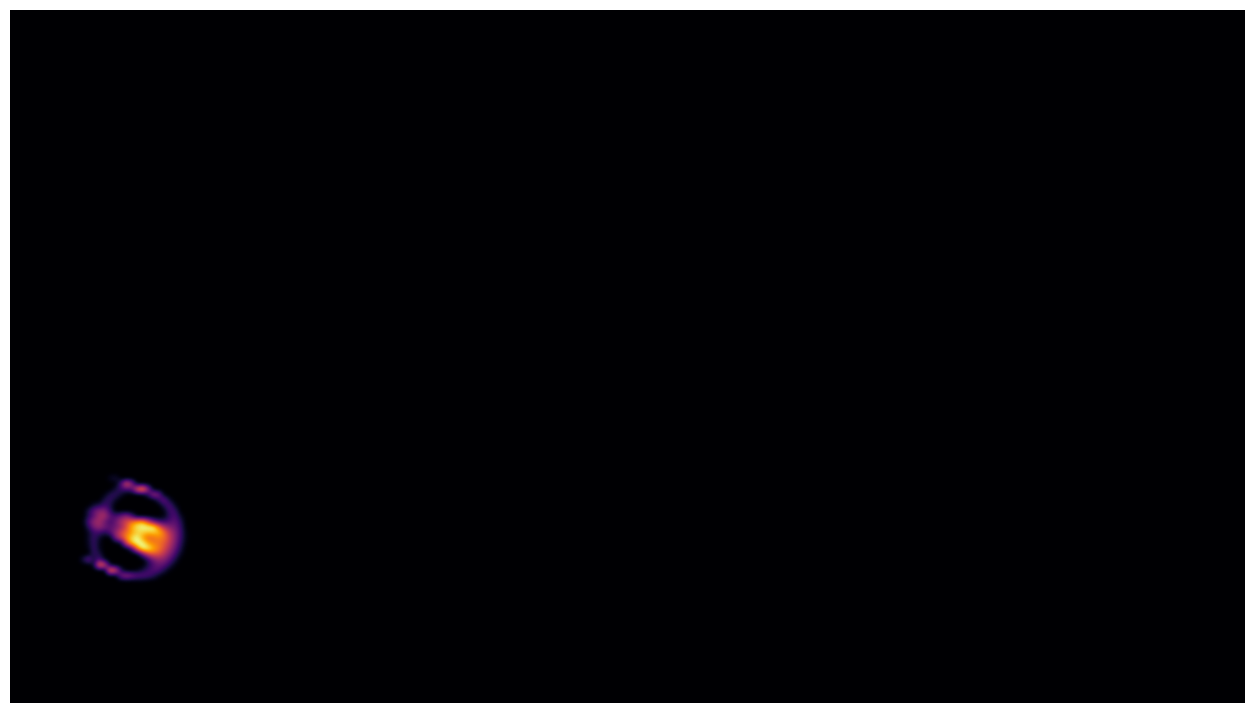

In [15]:
N = 128
M = int(np.ceil((16*N)/9))
X = np.zeros((N, M))
pos_x = M//6
pos_y = N//6
X[pos_x:(pos_x + orbium.shape[1]), pos_y:(pos_y + orbium.shape[0])] = orbium.T
plt.imshow(X, cmap='inferno')

produce_movie(X, evolve_lenia, '3-lenia_orbium.mp4', 800, cmap = 'inferno')

### Lenia with random initial configuration
We can check that a random initial configuration does not lead to moving pattern in general.

Step 0/100
Step 0/100
Step 0/100
Step 0/100
Step 10/100
Step 20/100
Step 30/100
Step 40/100
Step 50/100
Step 60/100
Step 70/100
Step 80/100
Step 90/100


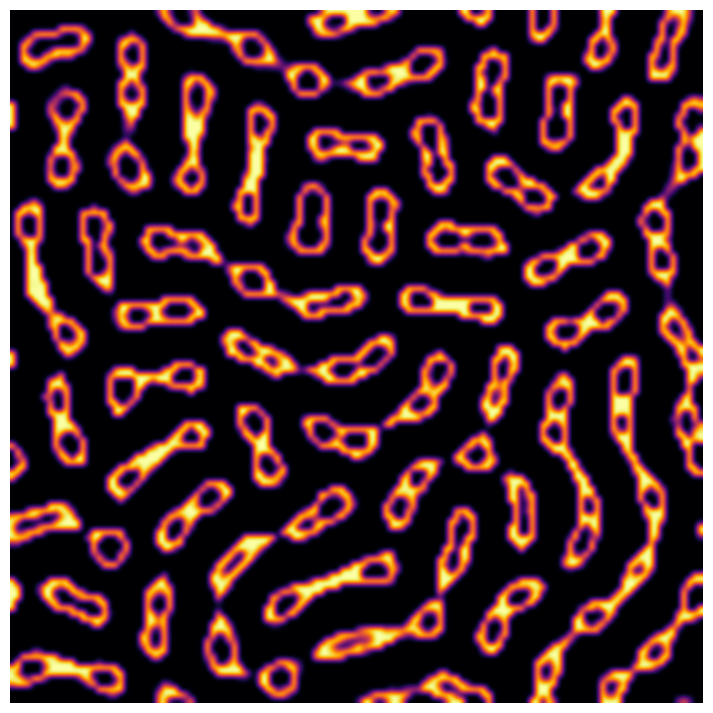

In [16]:
np.random.seed(42)
X = np.random.rand(N, N)
produce_movie(X, evolve_lenia, '4-lenia random.mp4', 100, cmap = 'inferno')

## 4. Lenia with multi-ring kernel

We can generalize the convolution filter to multiple rings, with different strengths, and test it with the "Hydrogeminium" configuration.

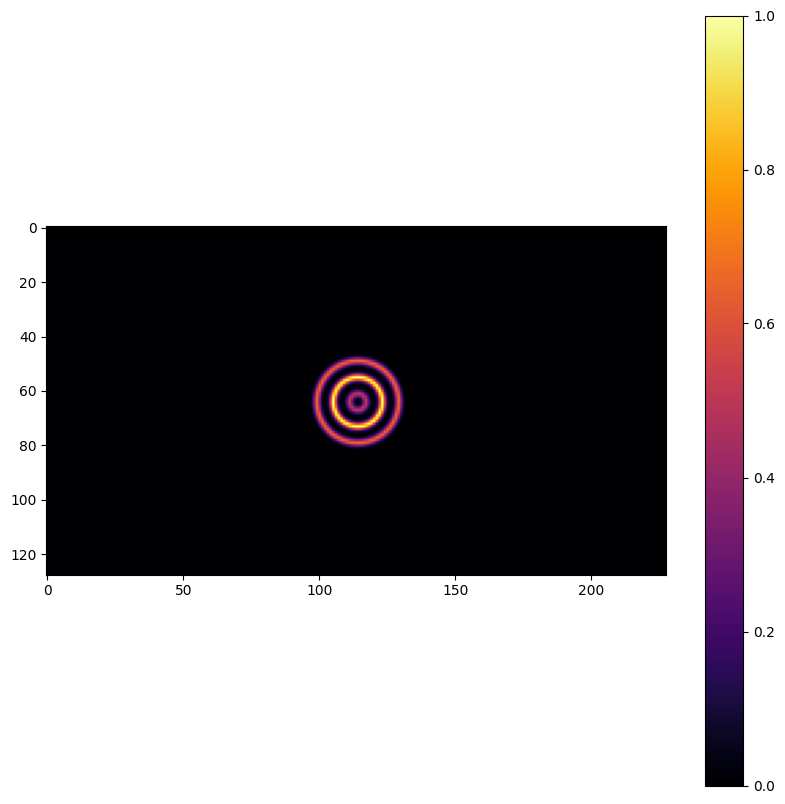

In [17]:
N = 128
M = int(np.ceil((16*N)/9))
X = np.zeros((N, M))

ring_strengths = [0.5, 1, 0.667]
nb_rings = len(ring_strengths)

R = 18
fhs_y = N // 2    # Filter half size
fhs_x = M // 2
y, x = np.ogrid[-fhs_y:fhs_y, -fhs_x:fhs_x]
distance = np.sqrt(x**2 + y**2) / R * nb_rings

# We create a multi-ring filter by summing the different gaussian rings
K_multiring = np.zeros_like(distance)
mu = 0.5
sigma = 0.15
for i in range(len(ring_strengths)):
    mask = (distance.astype(int) == i)      # The ith ring is at distance i
    K_multiring += mask * ring_strengths[i] * gauss(distance%1, mu, sigma)  # We use distance%1 to center the gaussian on the ring

plt.figure(figsize=(10, 10))
plt.imshow(K_multiring,cmap='inferno')
plt.colorbar()

We define the growth function as before with different values position and width of the gaussian.

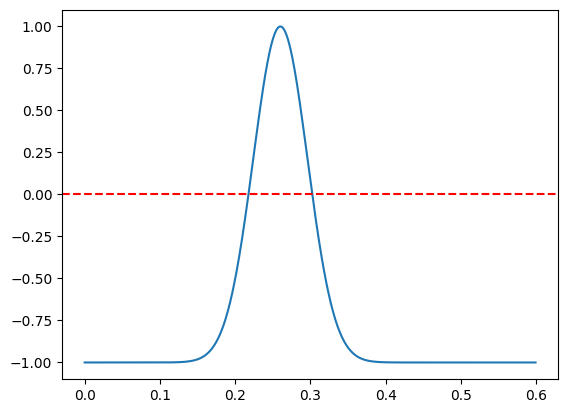

In [18]:
def growth_hydro(u):
    mu = 0.26
    sigma = 0.036
    return -1 + 2 * gauss(u,mu,sigma)        # Baseline -1, peak +1

a = np.arange(0, 0.6, 0.001)
plt.plot(a, growth_hydro(a))
plt.axhline(0, linestyle='--', color='red')

Following Bert Chan notebook, we use FFT to speed up the convolution : we compute the FFT of the filter and the array, multiply them and compute the inverse FFT.

In [19]:
dt = 0.1
fK = np.fft.fft2(np.fft.fftshift(K_multiring / np.sum(K_multiring)))
def evolve_hydro(X):
    U = np.real(np.fft.ifft2(fK * np.fft.fft2(X)))
    X = np.clip(X + dt * growth_hydro(U), 0, 1)
    return X

Load the "hydrogeminium" configuration and initialize the array with it.

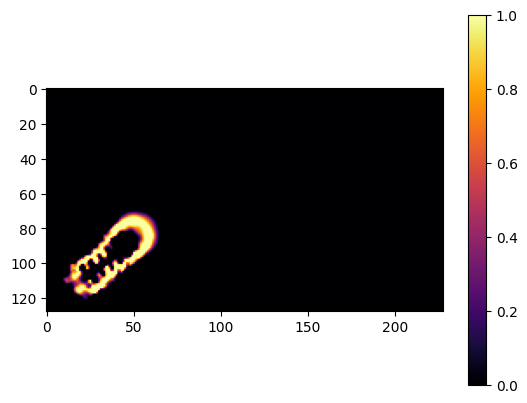

In [20]:
N = 128
M = int(np.ceil((16*N)/9))
X = np.zeros((N, M))

hydrogeminium = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.02,0.03,0.04,0.04,0.04,0.03,0.02,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.1,0.16,0.2,0.23,0.25,0.24,0.21,0.18,0.14,0.1,0.07,0.03,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.09,0.2,0.33,0.44,0.52,0.56,0.58,0.55,0.51,0.44,0.37,0.3,0.23,0.16,0.08,0.01,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.29,0.45,0.6,0.75,0.85,0.9,0.91,0.88,0.82,0.74,0.64,0.55,0.46,0.36,0.25,0.12,0.03,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.38,0.6,0.78,0.93,1.0,1.0,1.0,1.0,1.0,1.0,0.99,0.89,0.78,0.67,0.56,0.44,0.3,0.15,0.04,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08,0.39,0.74,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.85,0.74,0.62,0.47,0.3,0.14,0.03,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.76,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.75,0.61,0.45,0.27,0.11,0.01,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.35,0.83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.73,0.57,0.38,0.19,0.05,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,0.99,1.0,1.0,1.0,1.0,1.0,1.0,0.85,0.67,0.47,0.27,0.11,0.01], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.55,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.83,0.79,0.84,0.88,0.89,0.9,0.93,0.98,1.0,1.0,1.0,1.0,0.98,0.79,0.57,0.34,0.15,0.03], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.47,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.72,0.54,0.44,0.48,0.6,0.7,0.76,0.82,0.91,0.99,1.0,1.0,1.0,1.0,0.91,0.67,0.41,0.19,0.05], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.27,0.99,1.0,1.0,1.0,1.0,0.9,0.71,0.65,0.55,0.38,0.2,0.14,0.21,0.36,0.52,0.64,0.73,0.84,0.95,1.0,1.0,1.0,1.0,1.0,0.78,0.49,0.24,0.07], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.63,0.96,1.0,1.0,1.0,0.84,0.17,0,0,0,0,0,0,0,0.13,0.35,0.51,0.64,0.77,0.91,0.99,1.0,1.0,1.0,1.0,0.88,0.58,0.29,0.09], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.38,0.72,0.95,1.0,1.0,1.0,0.22,0,0,0,0,0,0,0,0,0,0.11,0.33,0.5,0.67,0.86,0.99,1.0,1.0,1.0,1.0,0.95,0.64,0.33,0.1], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.49,0.71,0.93,1.0,1.0,1.0,0.56,0,0,0,0,0,0,0,0,0,0,0,0.1,0.31,0.52,0.79,0.98,1.0,1.0,1.0,1.0,0.98,0.67,0.35,0.11], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.6,0.83,0.98,1.0,1.0,0.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15,0.38,0.71,0.97,1.0,1.0,1.0,1.0,0.97,0.67,0.35,0.11], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,0.96,1.0,1.0,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.09,0.34,0.68,0.95,1.0,1.0,1.0,1.0,0.91,0.61,0.32,0.1], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.56,0.99,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17,0.45,0.76,0.96,1.0,1.0,1.0,1.0,0.82,0.52,0.26,0.07], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.7,0.94,1.0,1.0,0.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,0.68,0.91,0.99,1.0,1.0,1.0,1.0,0.71,0.42,0.19,0.03], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.53,0.89,1.0,1.0,1.0,0.8,0.43,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.47,0.86,1.0,1.0,1.0,1.0,1.0,0.95,0.58,0.32,0.12,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.77,0.99,1.0,0.97,0.58,0.41,0.33,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.54,0.95,1.0,1.0,1.0,1.0,1.0,0.8,0.44,0.21,0.06,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.39,0.83,1.0,1.0,0.55,0.11,0.05,0.15,0.22,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.58,0.99,1.0,1.0,1.0,1.0,1.0,0.59,0.29,0.11,0.01,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.55,0.81,0.86,0.97,1.0,1.0,0.5,0,0,0.01,0.09,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0.26,0.78,1.0,1.0,1.0,1.0,1.0,0.66,0.35,0.13,0.03,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.33,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.23,0.73,0.95,1.0,1.0,1.0,1.0,1.0,0.62,0.35,0.12,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.56,0.25,0.09,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.12,0.38,1.0,1.0,1.0,0.66,0.08,0.55,1.0,1.0,1.0,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0.35,1.0,1.0,1.0,1.0,1.0,1.0,0.67,0.12,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.6,1.0,1.0,1.0,1.0,1.0,1.0,0.49,0,0,0.87,1.0,0.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.7,0.07,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.04,0.21,0.48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0.04,0.42,0.26,0,0,0,0,0,0,0,0,0,0.12,0.21,0.34,0.58,1.0,1.0,1.0,0.99,0.97,0.99,0.46,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.5,1.0,1.0,1.0,1.0,0.96,0,0.31,1.0,1.0,1.0,0.53,0,0,0,0,0,0,0,0,0.2,0.21,0,0,0,0.27,1.0,1.0,1.0,1.0,1.0,1.0,0.87,0.52,0.01,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.84,1.0,1.0,1.0,1.0,1.0,0,0,0,0.83,1.0,1.0,0.52,0,0,0,0,0,0,0,0.26,0.82,0.59,0.02,0,0,0.46,1.0,1.0,1.0,1.0,1.0,0.9,0.55,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.39,0.99,1.0,1.0,1.0,1.0,0.78,0.04,0,0,0,0.93,0.92,0,0,0,0,0,0,0,0,0.69,1.0,1.0,0.36,0,0,1.0,1.0,0.65,0.66,0.97,0.87,0.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.55,0.75,0.59,0.74,1.0,1.0,0,0,0.75,0.71,0.18,0,0,0,0,0,0,0,0,0,0,0.29,0,0,0.45,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.47,0.39,0.71,0.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.69,0.81,0.8,0.92,1.0,0.13,0,0,0.13,0.94,0.58,0,0,0,0,0,0,0,0,0,1.0,1.0,0.34,0,0.04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.63,0.85,0.9,0.98,1.0,0.09,0,0,0.02,1.0,0.64,0,0,0,0,0,0,0,0,0.59,1.0,1.0,0.84,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.64,0.65,0.67,1.0,1.0,0.21,0.01,0,0.04,0.02,0,0,0,0,0,0,0,0,0,0.69,1.0,1.0,1.0,0.29,0.37,1.0,1.0,0.6,0.63,1.0,0.84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.44,0.73,0.73,0.85,1.0,0.97,0.23,0.05,0,0,0,0,0,0,0,0,0.06,0,0,0,0.97,1.0,1.0,1.0,1.0,1.0,1.0,0.33,0.24,0.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.12,0.55,0.9,0.9,1.0,1.0,1.0,0.43,0.04,0,0,0,0,0,0,0,0.31,0.54,0,0,0,0.88,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.29,0.71,1.0,1.0,1.0,1.0,0.79,0.28,0,0,0,0,0,0,0,0,0.4,0.77,0.54,0,0,0.87,1.0,1.0,1.0,1.0,1.0,0.31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0.16,0.27,0.41,0.72,0.99,1.0,1.0,0.82,0.42,0.09,0,0,0,0,0,0,0,0,0.1,0.55,0.58,0.58,0.77,0.99,1.0,1.0,1.0,1.0,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0.31,0.48,0.45,0.46,0.63,0.88,1.0,0.83,0.59,0.28,0.06,0,0,0,0,0,0,0,0,0,0.32,0.7,0.95,1.0,1.0,1.0,1.0,0.7,0.58,0.12,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0.23,0.54,0.53,0.48,0.57,0.59,0.65,0.63,0.55,0.35,0.13,0.03,0.02,0.09,0.74,1.0,0.09,0,0,0,0.32,0.86,1.0,1.0,1.0,1.0,0.57,0.44,0.31,0.16,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0.31,0.45,0.31,0.18,0.28,0.39,0.47,0.54,0.5,0.35,0.2,0.16,0.28,0.75,1.0,0.42,0.01,0,0,0.6,1.0,1.0,1.0,1.0,0.51,0.29,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.14,0.3,0.4,0.54,0.71,0.74,0.65,0.49,0.35,0.27,0.47,0.6,0.6,0.72,0.98,1.0,1.0,1.0,1.0,0.65,0.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.33,0.53,0.69,0.94,0.99,1.0,0.84,0.41,0.16,0.15,0.96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.73,0.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.42,0.86,0.98,0.98,0.99,1.0,0.94,0.63,0.32,0.62,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.65,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.07,0.62,0.95,1.0,1.0,0.99,0.98,0.99,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.03,0.46,0.89,1.0,1.0,0.97,0.83,0.75,0.81,0.94,1.0,1.0,1.0,1.0,0.99,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.14,0.57,0.88,0.93,0.81,0.58,0.45,0.48,0.64,0.86,0.97,0.99,0.99,0.42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.23,0.45,0.47,0.39,0.29,0.19,0.2,0.46,0.28,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.08,0.22,0.24,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.07,0.22,0.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

pos_x,pos_y = 70,10
X[pos_x:pos_x + hydrogeminium.shape[0], pos_y:pos_y + hydrogeminium.shape[1]] = hydrogeminium
plt.imshow(X, cmap='inferno')
plt.colorbar()

Step 0/500
Step 0/500
Step 0/500
Step 0/500
Step 50/500
Step 100/500
Step 150/500
Step 200/500
Step 250/500
Step 300/500
Step 350/500
Step 400/500
Step 450/500


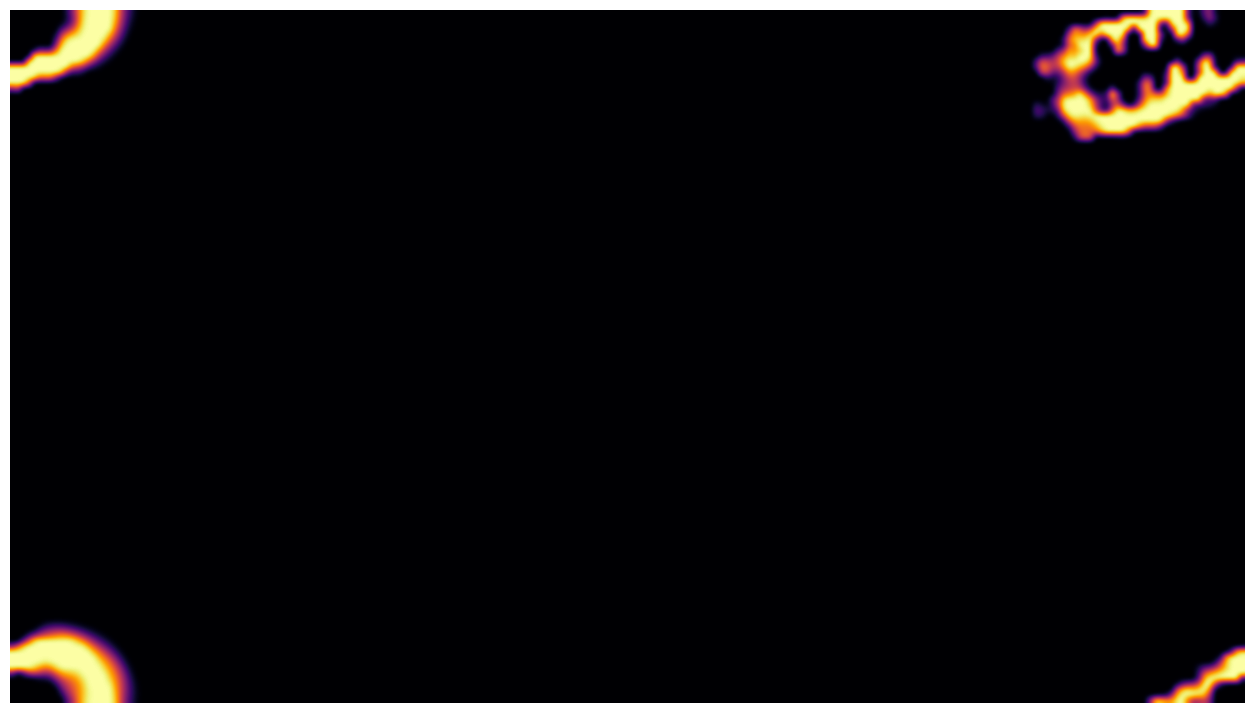

In [21]:
produce_movie(X, evolve_hydro, '5-hydrogeminium.mp4', 500, cmap = 'inferno')

## Multiple couples (filter,growth)

Step 0/400
Step 0/400
Step 0/400
Step 0/400
Step 40/400
Step 80/400
Step 120/400
Step 160/400
Step 200/400
Step 240/400
Step 280/400
Step 320/400
Step 360/400


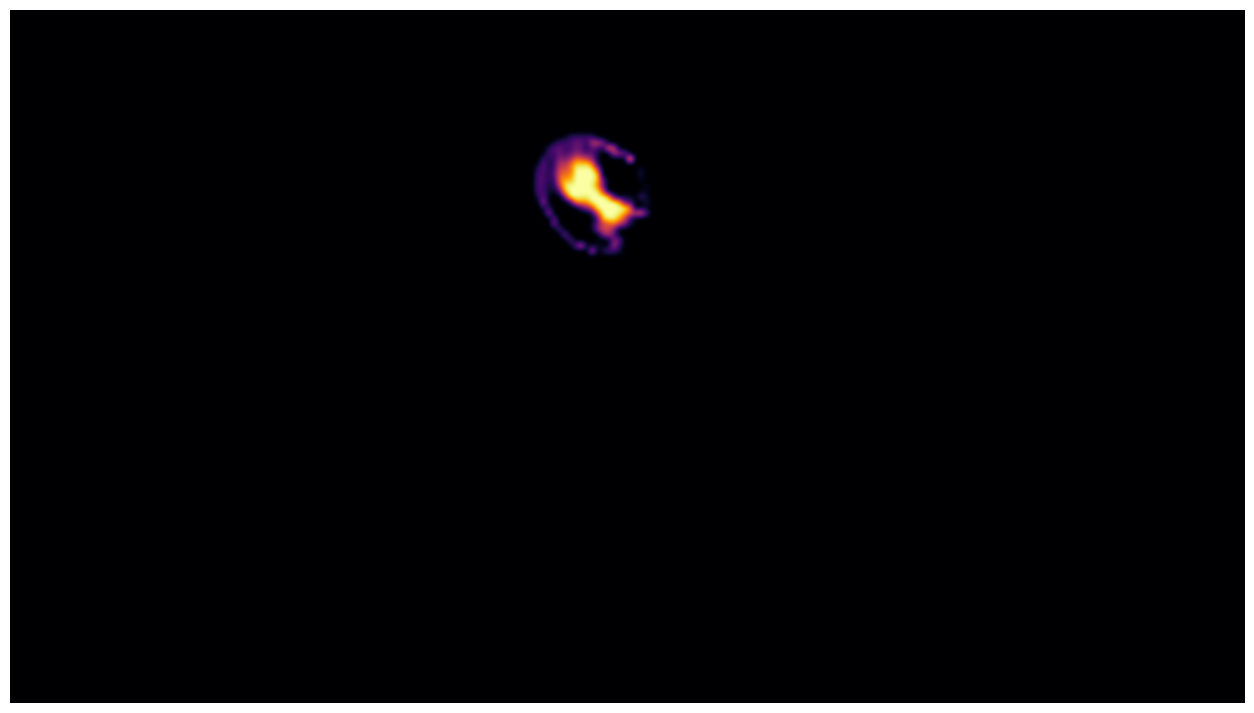

In [22]:
bs = [[1,5/12,2/3],[1/12,1],[1]]
ms = [0.156,0.193,0.342]
ss = [0.0118,0.049,0.0891]
R = 10

fish = np.array([[0,0,0,0,0,0,0,0,0,0,0,0.06,0.1,0.04,0.02,0.01,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.15,0.37,0.5,0.44,0.19,0.23,0.3,0.23,0.15,0.01,0,0,0,0], [0,0,0,0,0,0,0.32,0.78,0.26,0,0.11,0.11,0.1,0.08,0.18,0.16,0.17,0.24,0.09,0,0,0], [0,0,0,0,0.45,0.16,0,0,0,0,0,0.15,0.15,0.16,0.15,0.1,0.09,0.21,0.24,0.12,0,0], [0,0,0,0.1,0,0,0,0,0,0,0,0.17,0.39,0.43,0.34,0.25,0.15,0.16,0.15,0.25,0.03,0], [0,0.15,0.06,0,0,0,0,0,0,0,0.24,0.72,0.92,0.85,0.61,0.47,0.39,0.27,0.12,0.18,0.17,0], [0,0.08,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,0.73,0.6,0.56,0.31,0.12,0.15,0.24,0.01], [0,0.16,0,0,0,0,0,0,0,0.76,1.0,1.0,1.0,1.0,0.76,0.72,0.65,0.39,0.1,0.17,0.24,0.05], [0,0.05,0,0,0,0,0,0,0.21,0.83,1.0,1.0,1.0,1.0,0.86,0.85,0.76,0.36,0.17,0.13,0.21,0.07], [0,0.05,0,0,0.02,0,0,0,0.4,0.91,1.0,1.0,1.0,1.0,1.0,0.95,0.79,0.36,0.21,0.09,0.18,0.04], [0.06,0.08,0,0.18,0.21,0.1,0.03,0.38,0.92,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0.31,0.12,0.07,0.25,0], [0.05,0.12,0.27,0.4,0.34,0.42,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.97,0.33,0.16,0.05,0.1,0.26,0], [0,0.25,0.21,0.39,0.99,1.0,1.0,1.0,1.0,1.0,1.0,0.86,0.89,0.94,0.83,0.13,0,0,0.04,0.21,0.18,0], [0,0.06,0.29,0.63,0.84,0.97,1.0,1.0,1.0,0.96,0.46,0.33,0.36,0,0,0,0,0,0.03,0.35,0,0], [0,0,0.13,0.22,0.59,0.85,0.99,1.0,0.98,0.25,0,0,0,0,0,0,0,0,0.34,0.14,0,0], [0,0,0,0,0.33,0.7,0.95,0.8,0.33,0.11,0,0,0,0,0,0,0,0.11,0.26,0,0,0], [0,0,0,0,0.16,0.56,0.52,0.51,0.4,0.18,0.01,0,0,0,0,0,0,0.42,0,0,0,0], [0,0,0,0,0.01,0,0.33,0.47,0.33,0.05,0,0,0,0,0,0,0.35,0,0,0,0,0], [0,0,0,0,0,0.26,0.32,0.13,0,0,0,0,0,0,0,0.34,0,0,0,0,0,0], [0,0,0,0,0,0.22,0.25,0.03,0,0,0,0,0,0,0.46,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.09,0.2,0.22,0.23,0.23,0.22,0.3,0.3,0,0,0,0,0,0,0,0]])

N = 128
M = int(np.ceil((16*N)/9))
X = np.zeros((N, M))

ring_strengths = [0.5, 1, 0.667]
nb_rings = len(ring_strengths)

fhs_y = N // 2    # Filter half size
fhs_x = M // 2
y, x = np.ogrid[-fhs_y:fhs_y, -fhs_x:fhs_x]

# Compute the (FFT of) the kernel filters, each being made of several rings
fKs = []
for b in bs:
    distance = np.sqrt(x**2 + y**2) / R * len(b)
    K = np.zeros_like(distance)
    mu = 0.5
    sigma = 0.15
    for i in range(len(b)):
        mask = (distance.astype(int) == i)
        K += mask * b[i] * gauss(distance%1, mu, sigma)
    fK = np.fft.fft2(np.fft.fftshift(K / np.sum(K)))
    fKs.append(fK)

dt = 0.2
def evolve_multiple_couples(X):
    Us = [np.real(np.fft.ifft2(fK * np.fft.fft2(X))) for fK in fKs]
    Gs = [2*gauss(U, ms[i], ss[i]) - 1 for i,U in enumerate(Us)]
    X = np.clip(X + dt * np.mean(Gs, axis=0), 0, 1)
    return X

X = np.zeros((N,M))
pos_x,pos_y = 100,100
X[pos_x:pos_x + fish.shape[0], pos_y:pos_y + fish.shape[1]] = fish

produce_movie(X, evolve_multiple_couples, '6-multiple_couples.mp4', 400, cmap = 'inferno')

## Multiple channels

In [23]:
kernels = [
  {"b":[1],"m":0.272,"s":0.0595,"h":0.138,"r":0.91,"c0":0,"c1":0},
  {"b":[1],"m":0.349,"s":0.1585,"h":0.48,"r":0.62,"c0":0,"c1":0},
  {"b":[1,1/4],"m":0.2,"s":0.0332,"h":0.284,"r":0.5,"c0":0,"c1":0},
  {"b":[0,1],"m":0.114,"s":0.0528,"h":0.256,"r":0.97,"c0":1,"c1":1},
  {"b":[1],"m":0.447,"s":0.0777,"h":0.5,"r":0.72,"c0":1,"c1":1},
  {"b":[5/6,1],"m":0.247,"s":0.0342,"h":0.622,"r":0.8,"c0":1,"c1":1},
  {"b":[1],"m":0.21,"s":0.0617,"h":0.35,"r":0.96,"c0":2,"c1":2},
  {"b":[1],"m":0.462,"s":0.1192,"h":0.218,"r":0.56,"c0":2,"c1":2},
  {"b":[1],"m":0.446,"s":0.1793,"h":0.556,"r":0.78,"c0":2,"c1":2},
  {"b":[11/12,1],"m":0.327,"s":0.1408,"h":0.344,"r":0.79,"c0":0,"c1":1},
  {"b":[3/4,1],"m":0.476,"s":0.0995,"h":0.456,"r":0.5,"c0":0,"c1":2},
  {"b":[11/12,1],"m":0.379,"s":0.0697,"h":0.67,"r":0.72,"c0":1,"c1":0},
  {"b":[1],"m":0.262,"s":0.0877,"h":0.42,"r":0.68,"c0":1,"c1":2},
  {"b":[1/6,1,0],"m":0.412,"s":0.1101,"h":0.43,"r":0.82,"c0":2,"c1":0},
  {"b":[1],"m":0.201,"s":0.0786,"h":0.278,"r":0.82,"c0":2,"c1":1}]

R = 12

bs = [k["b"] for k in kernels]
rs = [R * k["r"] for k in kernels]
ms = [k["m"] for k in kernels]
ss = [k["s"] for k in kernels]
hs = [k["h"] for k in kernels]
sources = [k["c0"] for k in kernels]
destinations = [k["c1"] for k in kernels]

# Compute the (FFT of) the kernel filters, each being made of several rings
N = 128
M = int(np.ceil((16*N)/9))
X = np.zeros((N, M))

fhs_y = N // 2    # Filter half size
fhs_x = M // 2
y, x = np.ogrid[-fhs_y:fhs_y, -fhs_x:fhs_x]


Ks = []
for b,r in zip(bs,rs):
    distance = np.sqrt(x**2 + y**2) / r * len(b)
    K = np.zeros_like(distance)
    mu = 0.5
    sigma = 0.15
    for i in range(len(b)):
        mask = (distance.astype(int) == i)
        K += mask * b[i] * gauss(distance%1, mu, sigma)
    Ks.append(K/np.sum(K))

fKs = []
for K in Ks:
    fK = np.fft.fft2(np.fft.fftshift(K))
    fKs.append(fK)

(94.0, 134.0)

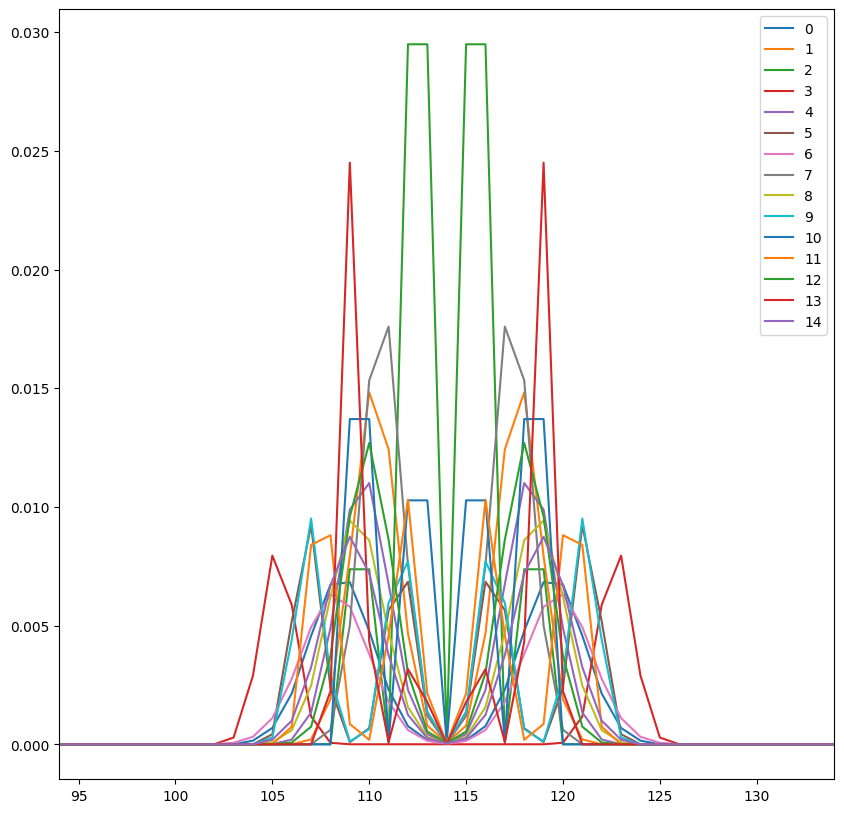

In [24]:
# Plot the cross section of the different K in Ks
plt.figure(figsize=(10,10))
for i,K in enumerate(Ks):
    plt.plot(K[N//2,:], label = i)
plt.legend()
plt.xlim(M//2 - 20, M//2 + 20)

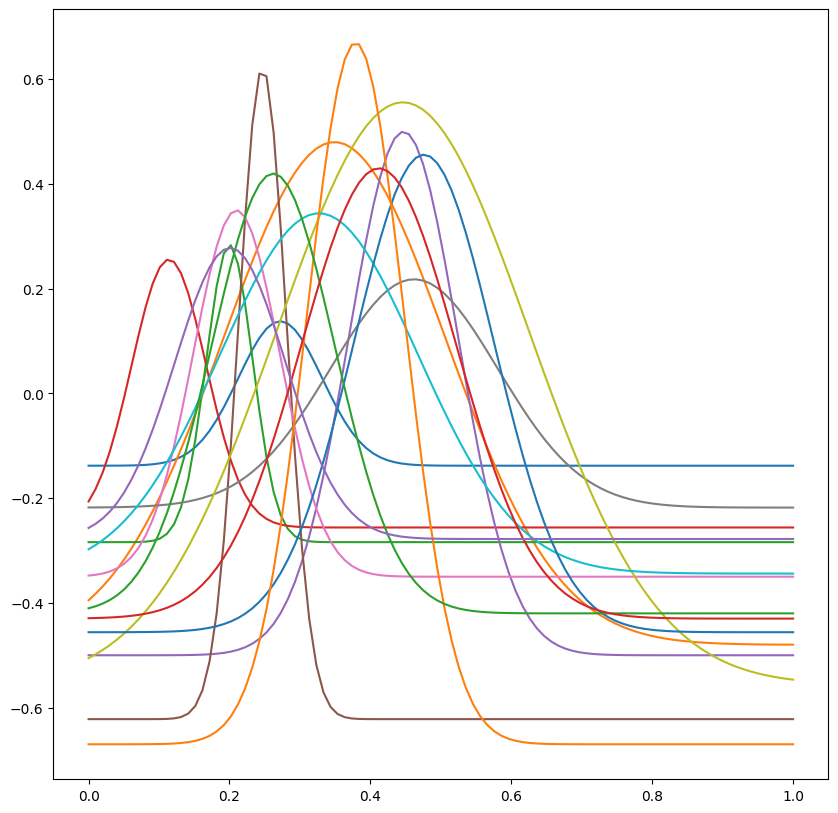

In [25]:
# Plot the growth function associated to the different ms and ss
plt.figure(figsize=(10,10))
for m,s,h in zip(ms,ss,hs):
    plt.plot(np.linspace(0,1,100), h*(2 * gauss(np.linspace(0,1,100), m, s) - 1))

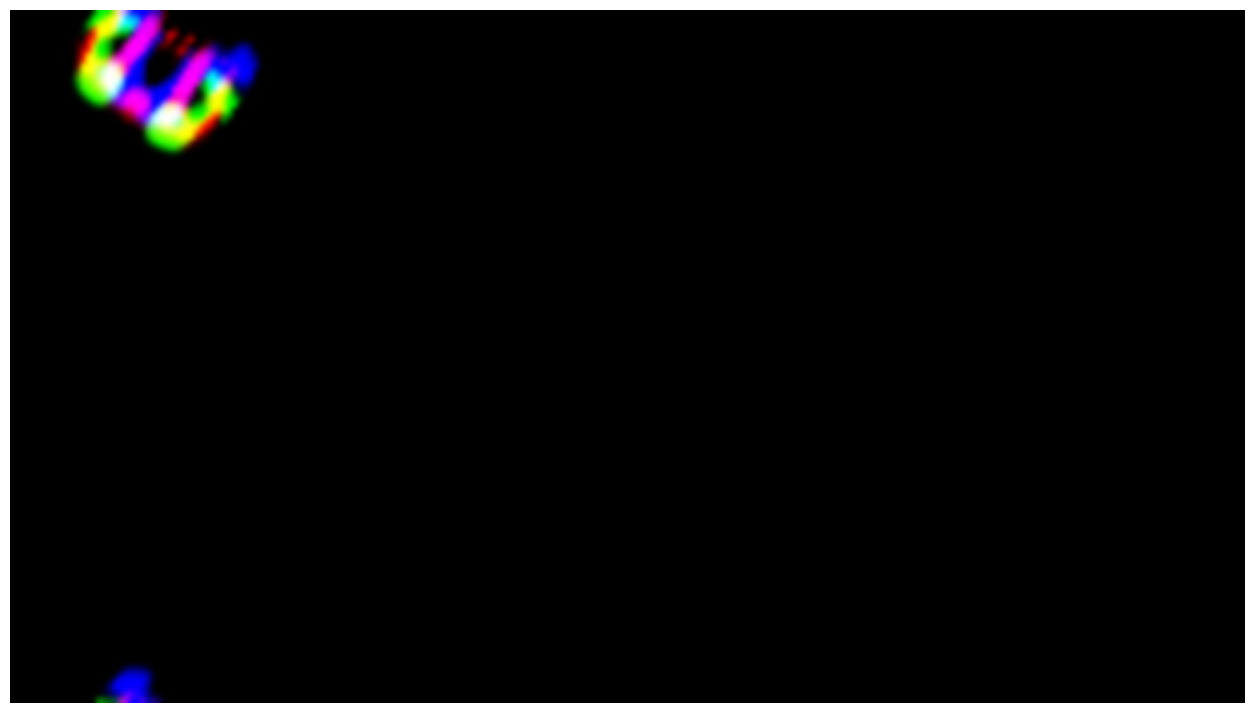

In [26]:
dt = 0.5
def evolve_multi_channels(Xs):
    fXs = [np.fft.fft2(X) for X in Xs]
    # For each kernel we compute the convolution with the corresponding source channel
    Us = [np.real(np.fft.ifft2(fK * fXs[source])) for fK,source in zip(fKs,sources)]
    # We compute the activation associated to each of those convolutions
    As = [2*gauss(U, ms[i], ss[i]) - 1 for i,U in enumerate(Us)]
    # Then we apply this activation to the corresponding destination channel with the corresponding strength
    Gs = np.zeros_like(Xs)
    for destination, h, A in zip(destinations, hs, As):
        Gs[destination] += h * A
    # Finally we update the channels
    Xs = [np.clip(X + dt * G, 0, 1) for X,G in zip(Xs,Gs)]
    return Xs



aquarium = [[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.49,1.0,0,0.03,0.49,0.49,0.28,0.16,0.03,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.6,0.47,0.31,0.58,0.51,0.35,0.28,0.22,0,0,0,0,0], [0,0,0,0,0,0,0.15,0.32,0.17,0.61,0.97,0.29,0.67,0.59,0.88,1.0,0.92,0.8,0.61,0.42,0.19,0,0,0], [0,0,0,0,0,0,0,0.25,0.64,0.26,0.92,0.04,0.24,0.97,1.0,1.0,1.0,1.0,0.97,0.71,0.33,0.12,0,0], [0,0,0,0,0,0,0,0.38,0.84,0.99,0.78,0.67,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.95,0.62,0.37,0,0], [0,0,0,0,0.04,0.11,0,0.69,0.75,0.75,0.91,1.0,1.0,0.89,1.0,1.0,1.0,1.0,1.0,1.0,0.81,0.42,0.07,0], [0,0,0,0,0.44,0.63,0.04,0,0,0,0.11,0.14,0,0.05,0.64,1.0,1.0,1.0,1.0,1.0,0.92,0.56,0.23,0], [0,0,0,0,0.11,0.36,0.35,0.2,0,0,0,0,0,0,0.63,1.0,1.0,1.0,1.0,1.0,0.96,0.49,0.26,0], [0,0,0,0,0,0.4,0.37,0.18,0,0,0,0,0,0.04,0.41,0.52,0.67,0.82,1.0,1.0,0.91,0.4,0.23,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0.05,0.45,0.89,1.0,0.66,0.35,0.09,0], [0,0,0.22,0,0,0,0.05,0.36,0.6,0.13,0.02,0.04,0.24,0.34,0.1,0,0.04,0.62,1.0,1.0,0.44,0.25,0,0], [0,0,0,0.43,0.53,0.58,0.78,0.9,0.96,1.0,1.0,1.0,1.0,0.71,0.46,0.51,0.81,1.0,1.0,0.93,0.19,0.06,0,0], [0,0,0,0,0.23,0.26,0.37,0.51,0.71,0.89,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.42,0.06,0,0,0], [0,0,0,0,0.03,0,0,0.11,0.35,0.62,0.81,0.93,1.0,1.0,1.0,1.0,1.0,0.64,0.15,0,0,0,0,0], [0,0,0,0,0,0,0.06,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.05,0.09,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.28,0.42,0.44,0.34,0.18,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.34,1.0,1.0,1.0,1.0,1.0,0.91,0.52,0.14,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.17,0.75,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.35,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.22,0.92,1.0,1.0,1.0,1.0,1.0,1.0,0.59,0.09], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.71,0.16], [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.67,0.83,0.85,1.0,1.0,1.0,1.0,1.0,1.0,0.68,0.17], [0,0,0,0,0,0,0,0,0,0,0,0,0.21,0.04,0.12,0.58,0.95,1.0,1.0,1.0,1.0,1.0,0.57,0.13], [0,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0.2,0.64,0.96,1.0,1.0,1.0,0.9,0.24,0.01], [0,0,0,0,0,0,0,0,0,0,0.13,0.29,0,0,0,0.25,0.9,1.0,1.0,1.0,1.0,0.45,0.05,0], [0,0,0,0,0,0,0,0,0,0,0.13,0.31,0.07,0,0.46,0.96,1.0,1.0,1.0,1.0,0.51,0.12,0,0], [0,0,0,0,0,0,0,0,0.26,0.82,1.0,0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3,0.05,0,0,0], [0,0,0,0,0,0,0,0,0.28,0.74,1.0,0.95,0.87,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.07,0.69,1.0,1.0,1.0,1.0,1.0,0.96,0.25,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.4,0.72,0.9,0.83,0.7,0.56,0.43,0.14,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.25,0.37,0.44,0.37,0.24,0.11,0.04,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.75,0.4,0.15,0,0,0,0], [0,0,0,0,0,0,0,0,0.14,0.48,0.83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0,0,0,0], [0,0,0,0,0,0,0,0,0.62,0.78,0.94,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0,0,0,0], [0,0,0,0,0,0,0,0.02,0.65,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.78,0,0,0,0], [0,0,0,0,0,0,0,0.15,0.48,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.79,0.05,0,0,0], [0,0,0,0,0,0,0.33,0.56,0.8,1.0,1.0,1.0,0.37,0.6,0.94,1.0,1.0,1.0,1.0,0.68,0.05,0,0,0], [0,0,0,0,0.35,0.51,0.76,0.89,1.0,1.0,0.72,0.15,0,0.29,0.57,0.69,0.86,1.0,0.92,0.49,0,0,0,0], [0,0,0,0,0,0.38,0.86,1.0,1.0,0.96,0.31,0,0,0,0,0.02,0.2,0.52,0.37,0.11,0,0,0,0], [0,0,0.01,0,0,0.07,0.75,1.0,1.0,1.0,0.48,0.03,0,0,0,0,0,0.18,0.07,0,0,0,0,0], [0,0.11,0.09,0.22,0.15,0.32,0.71,0.94,1.0,1.0,0.97,0.54,0.12,0.02,0,0,0,0,0,0,0,0,0,0], [0.06,0.33,0.47,0.51,0.58,0.77,0.95,1.0,1.0,1.0,1.0,0.62,0.12,0,0,0,0,0,0,0,0,0,0,0], [0.04,0.4,0.69,0.88,0.95,1.0,1.0,1.0,1.0,1.0,0.93,0.68,0.22,0.02,0,0,0.01,0,0,0,0,0,0,0], [0,0.39,0.69,0.91,1.0,1.0,1.0,1.0,1.0,0.85,0.52,0.35,0.24,0.17,0.07,0,0,0,0,0,0,0,0,0], [0,0,0.29,0.82,1.0,1.0,1.0,1.0,1.0,1.0,0.67,0.29,0.02,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.2,0.51,0.77,0.96,0.93,0.71,0.4,0.16,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.08,0.07,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0]]]

aquarium = [np.array(aquarium[c]) for c in range(3)]

Xs = [np.zeros((N, M)) for _ in range(3)]
pos_x,pos_y = N//2,N//2

for c in range(3):
    Xs[c][pos_x:pos_x + aquarium[c].shape[0], pos_y:pos_y + aquarium[c].shape[1]] = aquarium[c]

# plt.subplot(1,2,1)
# plt.imshow(np.dstack(Xs))
#
# for _ in range(20):
#     Xs = evolve_multi_channels(Xs)
#
# plt.subplot(1,2,2)
# plt.imshow(np.dstack(Xs))

produce_movie_multi(Xs, evolve_multi_channels, "7-aquarium.mp4", 200)